# Bird PAM Capstone - Baseline Model Training

This notebook trains the baseline CNN model for bird species classification using **Google Colab GPU**.

## Setup Instructions:
1. Open this notebook in **Google Colab** (File → Open in Colab, or upload to Colab)
2. Select a GPU runtime: Runtime → Change runtime type → GPU (T4 is free)
3. Run cell 1 to mount Google Drive
4. Run cells sequentially

## What You'll Need:
- ✅ Audio files in Google Drive: `Colab Notebooks/DSA 598/data/raw/`
- ✅ Split files: `train_ids.txt`, `val_ids.txt` (will be uploaded)
- ✅ Free T4 GPU with 16GB VRAM
- ✅ Results saved to Google Drive: `Colab Notebooks/DSA 598/outputs/`

## How It Works

This notebook:
- Mounts your Google Drive to access audio files
- Uses your existing dataset in `Colab Notebooks/DSA 598/data/raw/`
- Trains on Colab's free T4 GPU (much faster than CPU)
- Saves outputs back to Google Drive
- No Windows PyTorch DLL issues (runs on Linux)!

## 1. Setup Environment and Paths

First, detect the environment and configure paths:

In [1]:
import os
from pathlib import Path

# Detect if we're running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running on Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

if IN_COLAB:
    # Mount Google Drive to access your audio files
    from google.colab import drive
    drive.mount('/content/drive')

    # All paths use Colab's file system
    PROJECT_ROOT = Path('/content')
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DSA 598/data/raw'

    print("\n✓ Google Colab configured")
    print(f"  Project root: {PROJECT_ROOT}")
    print(f"  Data path (Google Drive): {DATA_PATH}")
else:
    # Running locally (not typical for this notebook)
    PROJECT_ROOT = Path('c:/Users/darcyme/Documents/Poly/Project/bird-pam-capstone')
    DATA_PATH = 'H:/My Drive/Colab Notebooks/DSA 598/data/raw'

    print("\n✓ Local paths configured:")
    print(f"  Project root: {PROJECT_ROOT}")
    print(f"  Data path: {DATA_PATH}")

# Verify data access
if os.path.exists(DATA_PATH):
    species_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
    print(f"\n✓ Found {len(species_folders)} species folders:")
    for folder in sorted(species_folders)[:5]:  # Show first 5
        print(f"  - {folder}")
    if len(species_folders) > 5:
        print(f"  ... and {len(species_folders) - 5} more")

    # Count total audio files
    total_files = 0
    for folder in species_folders:
        folder_path = os.path.join(DATA_PATH, folder)
        wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        total_files += len(wav_files)
    print(f"\n✓ Total audio files: {total_files}")
else:
    print(f"\n⚠️  Dataset not accessible at: {DATA_PATH}")
    print("Make sure Google Drive is mounted correctly")

✓ Running on Google Colab
Mounted at /content/drive

✓ Google Colab configured
  Project root: /content
  Data path (Google Drive): /content/drive/MyDrive/Colab Notebooks/DSA 598/data/raw

✓ Found 13 species folders:
  - Agelaius_phoeniceus
  - Baeolophus_bicolor
  - Cardinalis_cardinalis
  - Cyanocitta-cristata
  - Haemorhous_mexicanus
  ... and 8 more

✓ Total audio files: 1513


## 2. Upload Split Files (Colab Only)

Create directory structure and prepare for split file uploads:

In [4]:
# Upload split files from your computer
if IN_COLAB:
    from google.colab import files
    import os

    # Create directory
    os.makedirs('/content/conf/splits', exist_ok=True)

    print("📁 Upload your split files:")
    print("   1. train_ids.txt")
    print("   2. val_ids.txt")
    print("\nClick 'Choose Files' below and select BOTH files:")

    uploaded = files.upload()

    # Move uploaded files to correct location
    for filename in uploaded.keys():
        os.rename(f'/content/{filename}', f'/content/conf/splits/{filename}')
        print(f"✓ Uploaded: {filename}")

    # Verify files
    if os.path.exists('/content/conf/splits/train_ids.txt'):
        with open('/content/conf/splits/train_ids.txt', 'r') as f:
            train_count = len([l for l in f if l.strip()])
        print(f"  - train_ids.txt: {train_count} recordings")

    if os.path.exists('/content/conf/splits/val_ids.txt'):
        with open('/content/conf/splits/val_ids.txt', 'r') as f:
            val_count = len([l for l in f if l.strip()])
        print(f"  - val_ids.txt: {val_count} recordings")
else:
    print("✓ Running locally - split files should already exist")


📁 Upload your split files:
   1. train_ids.txt
   2. val_ids.txt

Click 'Choose Files' below and select BOTH files:


Saving train_ids.txt to train_ids.txt
Saving val_ids.txt to val_ids.txt
✓ Uploaded: train_ids.txt
✓ Uploaded: val_ids.txt
  - train_ids.txt: 1058 recordings
  - val_ids.txt: 226 recordings


## 3. Load Configuration and Setup

In [7]:
import sys
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
from tqdm.notebook import tqdm
import json
from sklearn.metrics import f1_score

# Create necessary files and directories
if IN_COLAB:
    import os

    # Create directories
    os.makedirs('/content/conf/splits', exist_ok=True)
    os.makedirs('/content/src/models', exist_ok=True)
    os.makedirs('/content/outputs', exist_ok=True)

    print("✓ Creating project files...")

    # Check if baseline_model.py exists
    if not os.path.exists('/content/src/models/baseline_model.py'):
        print("\n❌ baseline_model.py not found. Creating it now...")
        with open('/content/src/models/baseline_model.py', 'w') as f:
            f.write('''import torch
import torch.nn as nn

class BaselineCNN(nn.Module):
    """Baseline CNN for bird species classification from mel spectrograms."""

    def __init__(self, num_classes, n_mels=128,
                 conv_channels=[32, 64, 128, 256],
                 kernel_sizes=[5, 5, 3, 3],
                 pool_sizes=[2, 2, 2, 2],
                 dropout=0.3,
                 activation='relu'):
        super(BaselineCNN, self).__init__()

        self.num_classes = num_classes
        self.n_mels = n_mels

        layers = []
        in_channels = 1

        for i, out_channels in enumerate(conv_channels):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_sizes[i], padding=kernel_sizes[i]//2))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True) if activation == 'relu' else nn.ELU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=pool_sizes[i]))
            if i >= 2:
                layers.append(nn.Dropout2d(dropout))
            in_channels = out_channels

        self.features = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(conv_channels[-1], num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def create_model(config, num_classes):
    model_cfg = config.get('model', {})
    mel_cfg = config['melspec']
    return BaselineCNN(
        num_classes=num_classes,
        n_mels=mel_cfg.get('n_mels', 128),
        conv_channels=model_cfg.get('conv_channels', [32, 64, 128, 256]),
        kernel_sizes=model_cfg.get('kernel_sizes', [5, 5, 3, 3]),
        pool_sizes=model_cfg.get('pool_sizes', [2, 2, 2, 2]),
        dropout=model_cfg.get('dropout', 0.3),
        activation=model_cfg.get('activation', 'relu')
    )
''')
        print("✓ Created baseline_model.py")

    # Create default config if it doesn't exist
    if not os.path.exists('/content/conf/config.yaml'):
        print("❌ config.yaml not found. Creating default config...")
        with open('/content/conf/config.yaml', 'w') as f:
            f.write('''audio:
  sample_rate: 32000
  duration: 5.0
  hop_duration: 2.5
melspec:
  n_fft: 2048
  hop_length: 512
  n_mels: 128
  fmin: 500
  fmax: 12000
  power: 2.0

model:
  conv_channels: [32, 64, 128, 256]
  kernel_sizes: [5, 5, 3, 3]
  pool_sizes: [2, 2, 2, 2]
  dropout: 0.3
  activation: relu

train:
  batch_size: 32
  epochs: 10
  learning_rate: 0.001
  weight_decay: 0.0001
  optimizer: adam
  scheduler:
    type: ReduceLROnPlateau
    patience: 3
    factor: 0.5
  early_stopping:
    patience: 5
    min_delta: 0.001

paths:
  data_dir: /content/drive/MyDrive/DSA598_Project/Data
  splits_dir: /content/conf/splits
  output_dir: /content/outputs

seed: 42
''')
        print("  ✓ Created config.yaml")

sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from models.baseline_model import create_model

config_path = PROJECT_ROOT / 'conf' / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("\n✓ Configuration loaded:")
print(f"  Sample rate: {config['audio']['sample_rate']} Hz")
print(f"  Duration: {config['audio']['duration']} seconds")
print(f"  Mel bins: {config['melspec']['n_mels']}")
print(f"  Batch size: {config['train']['batch_size']}")
print(f"  Epochs: {config['train']['epochs']}")

# Update paths in config
config['paths']['data_dir'] = DATA_PATH
config['paths']['splits_dir'] = str(PROJECT_ROOT / 'conf' / 'splits')

# Set output_dir based on whether running in Colab
if IN_COLAB:
    config['paths']['output_dir'] = '/content/drive/MyDrive/Colab Notebooks/DSA 598/outputs'
else:
    config['paths']['output_dir'] = str(PROJECT_ROOT / 'outputs') # For local execution, if applicable

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

# Create output directory
import os
os.makedirs(config['paths']['output_dir'], exist_ok=True)


✓ Creating project files...

❌ baseline_model.py not found. Creating it now...
✓ Created baseline_model.py
❌ config.yaml not found. Creating default config...
  ✓ Created config.yaml

✓ Configuration loaded:
  Sample rate: 32000 Hz
  Duration: 5.0 seconds
  Mel bins: 128
  Batch size: 32
  Epochs: 10

✓ Using device: cuda
  GPU: Tesla T4


## 4. Create Dataset Class

In [19]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, audio_files, labels, config):
        self.audio_files = audio_files
        self.labels = labels
        self.config = config
        self.sr = config['audio']['sample_rate']
        self.duration = config['audio']['duration']
        self.mel_config = config['melspec']

        # Calculate the target number of time frames for mel spectrograms
        # This ensures all spectrograms have a consistent size for batching
        self.target_mel_frames = 1 + int(np.ceil(self.duration * self.sr / self.mel_config['hop_length']))

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Load audio
        audio_path = self.audio_files[idx]
        y, sr = librosa.load(audio_path, sr=self.sr, duration=self.duration, mono=True, res_type='sox_hq')

        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=self.mel_config['n_fft'],
            hop_length=self.mel_config['hop_length'],
            n_mels=self.mel_config['n_mels'],
            fmin=self.mel_config['fmin'],
            fmax=self.mel_config['fmax'],
            power=self.mel_config['power']
        )

        # Convert to log scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize to [0, 1]
        mel_spec_db = (mel_spec_db + 80) / 80  # Assuming -80 dB as minimum

        # Ensure fixed time dimension for mel spectrogram
        current_frames = mel_spec_db.shape[1]
        if current_frames < self.target_mel_frames:
            # Pad if shorter
            padding = self.target_mel_frames - current_frames
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, padding)), mode='constant')
        elif current_frames > self.target_mel_frames:
            # Crop if longer
            mel_spec_db = mel_spec_db[:, :self.target_mel_frames]

        # Add channel dimension
        mel_spec_db = mel_spec_db[np.newaxis, :, :]  # (1, n_mels, time)

        return torch.FloatTensor(mel_spec_db), self.labels[idx]

print("Dataset class created")

Dataset class created


## 5. Verify GPU Access (Colab Only)

Check if GPU is available and show GPU information:

In [20]:
if IN_COLAB:
    import torch
    print("🔍 Checking GPU availability...")
    print(f"\nPyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        print(f"\n✓ GPU detected!")
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
        print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"  CUDA version: {torch.version.cuda}")
    else:
        print("\n⚠️  No GPU detected!")
        print("To enable GPU:")
        print("  1. Click the runtime dropdown (top right)")
        print("  2. Select 'Change runtime type'")
        print("  3. Choose 'T4 GPU' or better")
        print("  4. Click 'Save' and reconnect")
else:
    print("✓ Running locally - GPU check only needed on Colab")

🔍 Checking GPU availability...

PyTorch version: 2.9.0+cu126
CUDA available: True

✓ GPU detected!
  GPU: Tesla T4
  Memory: 15.83 GB
  CUDA version: 12.6


## 6. Load Dataset Splits

In [21]:
def load_split(split_file):
    """Load recording IDs from split file."""
    with open(split_file, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def find_audio_files(data_dir, recording_ids):
    """Find audio files matching recording IDs."""
    audio_files = []
    labels = []
    species_to_idx = {}

    # Strip "XC" prefix from recording IDs for matching (e.g., "XC405825" -> "405825")
    recording_ids_clean = set()
    for rid in recording_ids:
        clean_id = rid.replace('XC', '') if rid.startswith('XC') else rid
        recording_ids_clean.add(clean_id)

    data_path = Path(data_dir)

    for species_folder in sorted(data_path.iterdir()):
        if not species_folder.is_dir():
            continue

        species_name = species_folder.name
        if species_name not in species_to_idx:
            species_to_idx[species_name] = len(species_to_idx)

        species_idx = species_to_idx[species_name]

        for audio_file in species_folder.glob('*.wav'):
            # Extract numeric ID from filename (e.g., "405825" from "405825_Mike_Ashby_9s.wav")
            recording_id = audio_file.stem.split('_')[0]
            if recording_id in recording_ids_clean:
                audio_files.append(str(audio_file))
                labels.append(species_idx)

    return audio_files, labels, species_to_idx

# Load splits
splits_dir = Path(config['paths']['splits_dir'])
train_ids = load_split(splits_dir / 'train_ids.txt')
val_ids = load_split(splits_dir / 'val_ids.txt')

print(f"Train IDs: {len(train_ids)}")
print(f"Val IDs: {len(val_ids)}")

# Find audio files
train_files, train_labels, species_map = find_audio_files(config['paths']['data_dir'], train_ids)
val_files, val_labels, _ = find_audio_files(config['paths']['data_dir'], val_ids)

print(f"\nFound {len(train_files)} training files")
print(f"Found {len(val_files)} validation files")
print(f"Number of species: {len(species_map)}")
print(f"\nSpecies mapping: {species_map}")

Train IDs: 1058
Val IDs: 226

Found 1058 training files
Found 226 validation files
Number of species: 13

Species mapping: {'Agelaius_phoeniceus': 0, 'Baeolophus_bicolor': 1, 'Cardinalis_cardinalis': 2, 'Cyanocitta-cristata': 3, 'Haemorhous_mexicanus': 4, 'Junco_hyemalis': 5, 'Melospiza_melodia': 6, 'Poecile_atricapillus': 7, 'Quiscalus_quiscula': 8, 'Spinus_tristis': 9, 'Turdus_migratorius': 10, 'Zenaida_macroura': 11, 'Zonotrichia_albicollis': 12}


## 7. Create DataLoaders

In [22]:
# Create datasets
train_dataset = MelSpectrogramDataset(train_files, train_labels, config)
val_dataset = MelSpectrogramDataset(val_files, val_labels, config)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['train']['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['train']['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 34
Val batches: 8


## 8. Create Model and Optimizer

In [23]:
# Create model
num_classes = len(species_map)
model = create_model(config, num_classes)
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Create optimizer and loss
optimizer = optim.Adam(
    model.parameters(),
    lr=config['train']['learning_rate'],
    weight_decay=config['train']['weight_decay']
)

criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=config['train']['scheduler']['patience'],
    factor=config['train']['scheduler']['factor']
)

print("\nModel, optimizer, and scheduler created")


Model Parameters:
  Total: 425,421
  Trainable: 425,421

Model, optimizer, and scheduler created


## 9. Training Functions

In [24]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, f1

print("Training functions defined")

Training functions defined


## 10. Train the Model

In [25]:
# Training loop
num_epochs = config['train']['epochs']
best_val_loss = float('inf')
patience_counter = 0
max_patience = config['train']['early_stopping']['patience']

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

# Create output directory (use local path)
output_dir = Path(config['paths']['output_dir'])
output_dir.mkdir(exist_ok=True, parents=True)

print(f"\nTraining for {num_epochs} epochs...")
print(f"Output directory: {output_dir}\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'config': config,
            'species_map': species_map
        }, output_dir / 'best_model.pth')
        print(f"✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{max_patience})")

    # Early stopping
    if patience_counter >= max_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, output_dir / f'checkpoint_epoch_{epoch+1}.pth')

# Save training history
with open(output_dir / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("\n" + "="*50)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Model saved to: {output_dir / 'best_model.pth'}")


Training for 10 epochs...
Output directory: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs


Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.5838 | Train Acc: 12.00%
Val Loss: 2.5327 | Val Acc: 14.16% | Val F1: 0.0760
✓ Saved best model (val_loss: 2.5327)

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.4881 | Train Acc: 13.52%
Val Loss: 2.4928 | Val Acc: 16.37% | Val F1: 0.1083
✓ Saved best model (val_loss: 2.4928)

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.4048 | Train Acc: 14.74%
Val Loss: 2.3979 | Val Acc: 19.03% | Val F1: 0.1282
✓ Saved best model (val_loss: 2.3979)

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.3943 | Train Acc: 18.05%
Val Loss: 2.4260 | Val Acc: 17.70% | Val F1: 0.1209
No improvement (1/5)

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.3169 | Train Acc: 21.36%
Val Loss: 2.3640 | Val Acc: 19.47% | Val F1: 0.1096
✓ Saved best model (val_loss: 2.3640)

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.2805 | Train Acc: 21.36%
Val Loss: 2.2995 | Val Acc: 17.26% | Val F1: 0.1044
✓ Saved best model (val_loss: 2.2995)

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.2093 | Train Acc: 24.01%
Val Loss: 2.2739 | Val Acc: 20.80% | Val F1: 0.1364
✓ Saved best model (val_loss: 2.2739)

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.1839 | Train Acc: 26.75%
Val Loss: 3.8158 | Val Acc: 14.60% | Val F1: 0.0956
No improvement (1/5)

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.1810 | Train Acc: 27.13%
Val Loss: 2.4296 | Val Acc: 20.80% | Val F1: 0.1604
No improvement (2/5)

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Train Loss: 2.1119 | Train Acc: 28.54%
Val Loss: 2.3359 | Val Acc: 25.22% | Val F1: 0.1805
No improvement (3/5)

Training complete!
Best validation loss: 2.2739
Model saved to: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/best_model.pth


## 11. Plot Training Curves

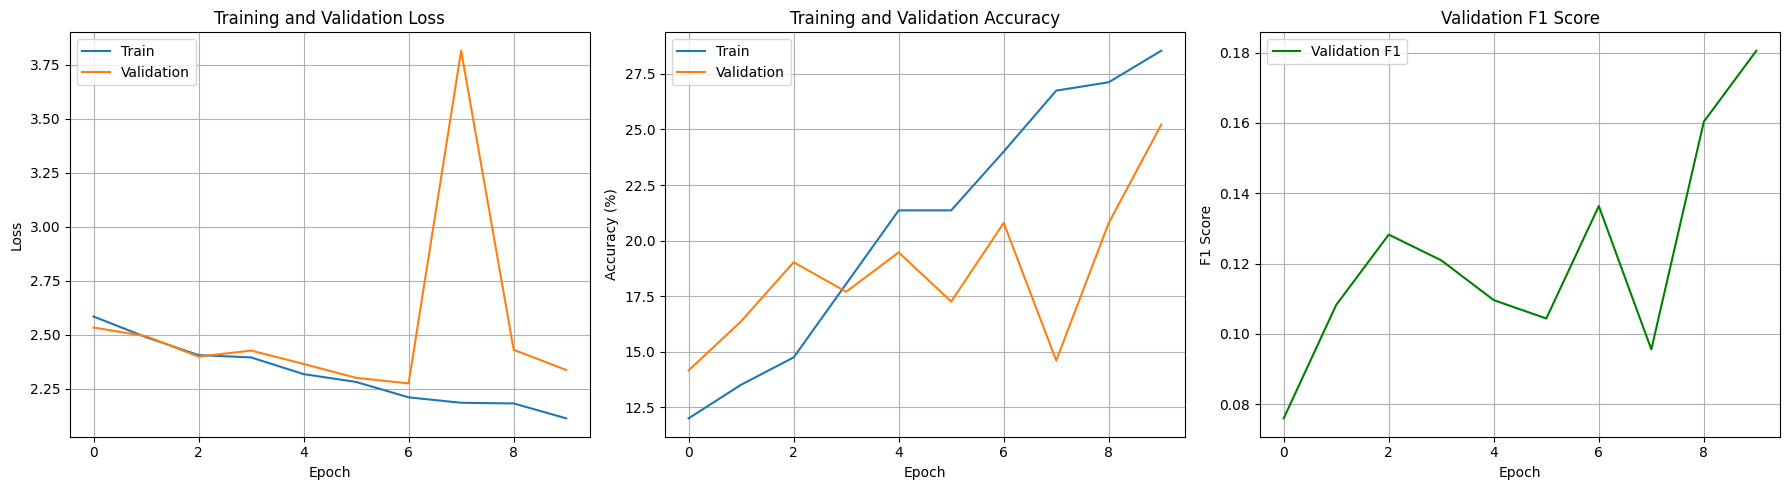

Training curves saved to: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/training_curves.png


In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# F1 Score
axes[2].plot(history['val_f1'], label='Validation F1', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(output_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {output_dir / 'training_curves.png'}")

## 12. Export Training Results

### Subtask:
Export the training history to a CSV file, save the model configuration and species mapping to JSON/YAML files, and regenerate the training curves as a PDF file, all within the output directory.


In [27]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Generate a timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Create a pandas DataFrame from the history dictionary
history_df = pd.DataFrame(history)

# 2. Save this DataFrame to a CSV file with a timestamp
history_csv_path = output_dir / f'training_history_{timestamp}.csv'
history_df.to_csv(history_csv_path, index=False)

# 3. Save the config dictionary to a JSON file with a timestamp
config_json_path = output_dir / f'model_config_{timestamp}.json'
with open(config_json_path, 'w') as f:
    json.dump(config, f, indent=2)

# 4. Save the species_map dictionary to a JSON file with a timestamp
species_map_json_path = output_dir / f'species_mapping_{timestamp}.json'
with open(species_map_json_path, 'w') as f:
    json.dump(species_map, f, indent=2)

# 5. Re-create the training curves plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# F1 Score
axes[2].plot(history['val_f1'], label='Validation F1', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

# 6. Save the re-created figure as a PDF file with a timestamp
curves_pdf_path = output_dir / f'training_curves_{timestamp}.pdf'
plt.savefig(curves_pdf_path, dpi=300, bbox_inches='tight')
plt.close(fig) # Close the figure to free up memory

# 7. Print the full paths of the saved files
print("\n--- Exported Training Results ---")
print(f"Training history CSV: {history_csv_path}")
print(f"Model configuration JSON: {config_json_path}")
print(f"Species mapping JSON: {species_map_json_path}")
print(f"Training curves PDF: {curves_pdf_path}")


--- Exported Training Results ---
Training history CSV: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/training_history.csv
Model configuration JSON: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/model_config.json
Species mapping JSON: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/species_mapping.json
Training curves PDF: /content/drive/MyDrive/Colab Notebooks/DSA 598/outputs/training_curves.pdf
